## ME 334: Advanced Dynamics, Control and System Identification
### Stanford University

# Target Tracking Problem

## Problem statement

<div>
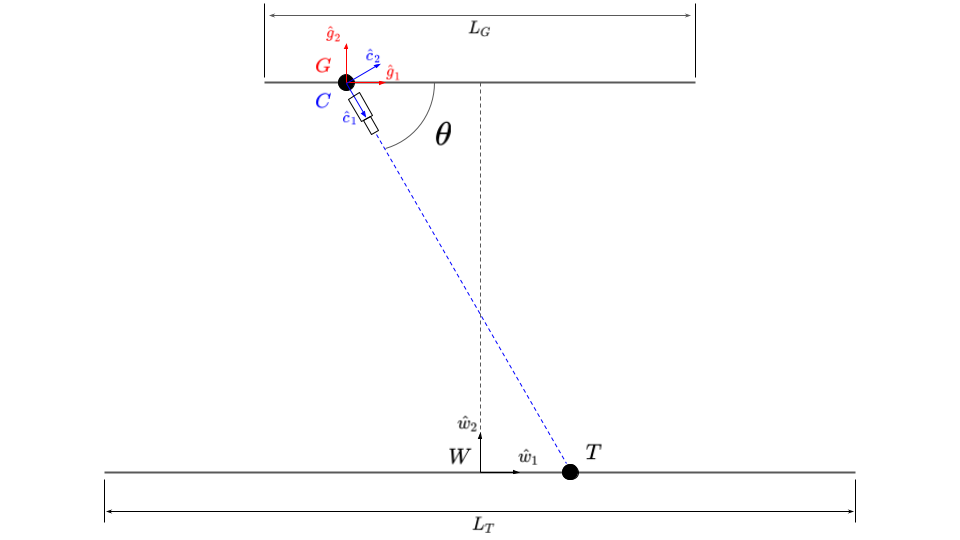
</div>


The goal of this assignment is to control the orientation of the camera SRT $C$ to track the target $T$, as they move on the top and bottom rails respectively. A horizontal sliding element moves on the top rail and has an SRT $G$ attached to it. You are given the positions of $G$ and $T$ as functions of time:

  $$p_T(t) = \begin{bmatrix} \frac{L_T}{2}\sin(a_Tt)\\0\\0 \end{bmatrix}, \quad
    p_G(t) = \begin{bmatrix} \frac{L_G}{2}\sin(a_Gt)\\h\\0 \end{bmatrix}.$$
   
   
To solve this problem:
1. First determine the desired orientation of the camera at any given time. This can be done in two steps. 
- Compute the angle $\theta$ made by the line of sight, i.e., the vector $\hat{\boldsymbol{c}}_1$ with the horizontal axis.
- Compute the 3-dimensional rotation matrix $^CR_G(\theta)$ describing the rotation of SRT $G$ to $C$ (a vector initially expressed with reference to $G$, when operated upon by this matrix, gets expressed w.r.t. $C$).
2. Next, determine a control law that ensures $\theta(t)$ tracks its desired value.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
%matplotlib notebook 
#ensure you run this to see plots/animations! for jupyter notebook

In [13]:
# physical and motion parameters
h = 10
L_T = 20
L_G = 12
a_T = 0.1
a_G = 0.2
times = np.linspace(0, 100, 1001)

For the period of time over which the system is being animated here, the positions of $G$ and $T$ can be computed at small, equally-spaced intervals:

In [14]:
# helper code for gantry and target positions
p_T = lambda t: np.array([(L_T / 2) * np.sin(a_T * t), 0, 0])
p_G = lambda t: np.array([(L_G / 2) * np.sin(a_G * t), h, 0])

Now, compute the *desired trajectory* $\theta(t)$ and the corresponding $^CR_G(\theta)$:

In [121]:
# [TODO] Fill in anything with a TODO tag in this block.
def get_theta_des(t):
    """The desired orientation trajectory.
    
    Parameters
    ----------
    t : np.ndarray, shape=(1)
        The current time.
        
    Returns
    -------
    theta : np.ndarray, shape=(1)
        The angle made between vectors c1 and g1.
    """
    # [TODO] FILL THIS FUNCTION IN
    
    T_pos = p_T(t)
    G_pos = p_G(t)
    g1_hat = np.array([1,0,0])
    
    p_cam = T_pos - G_pos
    
    theta = np.arctan2(np.linalg.norm(np.cross(g1_hat,p_cam)),np.dot(g1_hat,p_cam))
    
    #if T_pos[0] > G_pos[0]:
        #theta = np.arctan(h/(T_pos[0] - G_pos[0]))
    #elif T_pos[0] < G_pos[0]:
        #theta = (np.pi - np.arctan(h/(G_pos[0] - T_pos[0])))
    #else:
        #theta = np.pi/2
    return theta
    
def get_R_CG(theta):
    """The rotation matrix corresponding to a given angle between the SRTs.
    
    Parameters
    ----------
    theta : np.ndarray, shape=(1)
        The current angle between c1 and g1.
        
    Returns
    -------
    R : np.ndarray, shape=(3, 3)
        The rotation matrix between SRTs C and G.
    """
    # [TODO] FILL THIS FUNCTION IN
    R = np.array([[np.cos(theta), np.sin(theta), 0],[-np.sin(theta), np.cos(theta), 0],[0, 0, 1]])
    
    return R

Define a control law for the camera below.

In [122]:
# [TODO] Fill in anything with a TODO tag in this block.
def ctrl_camera(t, theta):
    """The control law for the camera angle.
    
    Parameters
    ----------
    t : np.ndarray, shape=(1)
        The current time. 
    theta : np.ndarray, shape=(1)
        The current angle between c1 and g1.
        
    Returns
    -------
    u : np.ndarray, shape=(1)
        The control input.
    """
    # [TODO] FILL THIS FUNCTION IN
    kp = 8 # larger Kp can reach desired angle faster
    theta_d = get_theta_des(t)

    return kp*(theta_d - theta)
    

The camera is subject to the first-order dynamics $\dot{\theta}=u(t, \theta)$. The solution of this differential equation gives you the *actual motion* $\theta(t)$ that results from the application of your chosen control law:

In [123]:
def dyn_camera(t, theta):
    dth = ctrl_camera(t, theta)
    return np.array([dth])

x0 = np.array([0, 0])
sol = solve_ivp(dyn_camera, [times[0], times[-1]], x0, t_eval=times)
theta_vals = sol.y[0, :]

Finally, the following code animates the system. Note the use of rotation matrices to transform and plot vectors in the animation.

<IPython.core.display.Javascript object>


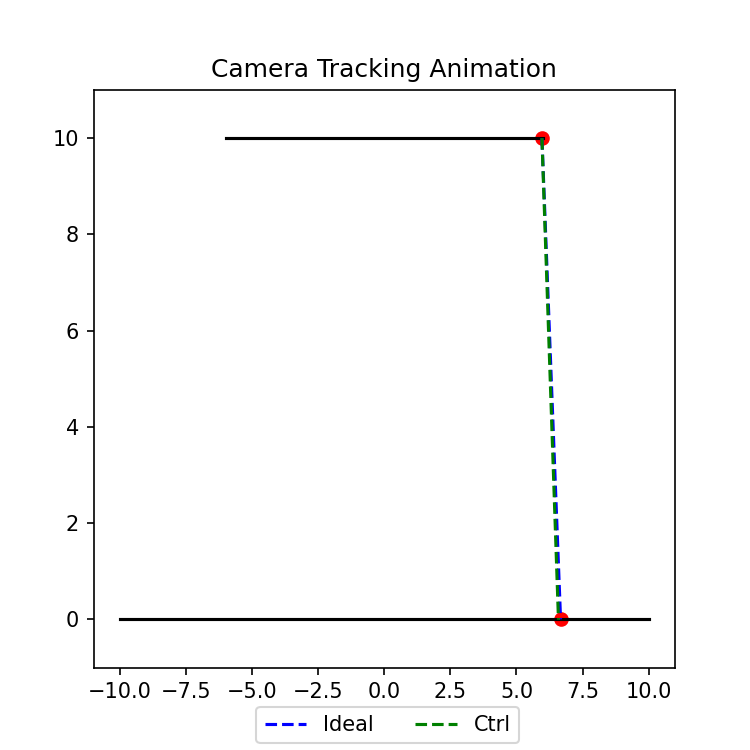

In [124]:
# animation helper
def anim_func(iteration):
    t = times[iteration]
    _p_T = p_T(t)
    _p_G = p_G(t)
    #first axis of the SRT G
    _g1_hat = np.array([1, 0, 0])
    
    #desired angle trajectory
    theta_des = get_theta_des(t) 
    #actual angle trajectory
    theta_ctrl = theta_vals[iteration] 
    
    #rotation matrices for desired and actual trajectories
    R_CG_ideal = get_R_CG(theta_des)
    R_CG_ctrl = get_R_CG(theta_ctrl)
    
    # plot's origin is different from W frame's origin
    
    # ideal tracking line
    TG_dist = np.linalg.norm(_p_T - _p_G)
    p_cam = R_CG_ideal @ _g1_hat / np.linalg.norm(R_CG_ideal @ _g1_hat)
    p_cam = TG_dist * p_cam + _p_G
    
    # ctrl tracking line
    p_ctrl = R_CG_ctrl @ _g1_hat / np.linalg.norm(R_CG_ctrl @ _g1_hat)
    p_ctrl = TG_dist * p_ctrl + _p_G
    
    points.set_offsets(np.array([[_p_T[0], _p_T[1]], [_p_G[0], _p_G[1]]]))
    line_ideal.set_data(np.array([_p_G[0], p_cam[0]]), np.array([_p_G[1], p_cam[1]]))
    line_ctrl.set_data(np.array([_p_G[0], p_ctrl[0]]), np.array([_p_G[1], p_ctrl[1]]))
    return points, line_ideal, line_ctrl

# plotting
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot([-L_T / 2, L_T / 2], [0, 0], color='black')
ax.plot([-L_G / 2, L_G / 2], [h, h], color='black')

points = ax.scatter([], [], color='red')
line_ideal, = ax.plot([], [], color='blue', linestyle='--')
line_ctrl, = ax.plot([], [], color='green', linestyle='--')

#Set limits on plot and show axis-labels
ax.set_xlim(-L_T / 2 - 1, L_T / 2 + 1)
ax.set_ylim(-1, h + 1)
ax.set_title('Camera Tracking Animation')
ax.legend([line_ideal, line_ctrl], ['Ideal', 'Ctrl'], bbox_to_anchor=(0.75, -0.05), ncol=2)

#Animate
ani = animation.FuncAnimation(fig, anim_func, frames=len(times), interval=5)

#Show animation on local machine (comment this out on colab)
plt.show()

#if using colab, uncomment the following
#from matplotlib import rc
#rc('animation', html='jshtml')
#ani